In [1]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
import matplotlib.pyplot as plt

In [63]:
elec_df = pd.read_csv('../data/big_demand_temp_train_by_day.csv', index_col=0)
elec_df.index = pd.DatetimeIndex(elec_df.index)
elec_df.rename({'day_demand' : 'y'}, axis=1, inplace=True)
elec_df['ds'] = elec_df.index
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2015-07-06 to 2017-11-03
Data columns (total 10 columns):
y           852 non-null float64
CA_pop      852 non-null float64
la_high     852 non-null float64
sd_high     852 non-null float64
sj_high     852 non-null float64
sf_high     852 non-null float64
sac_high    852 non-null float64
f_high      852 non-null float64
DOW         852 non-null float64
ds          852 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(9)
memory usage: 73.2 KB


In [3]:
train_len = int(0.5 * elec_df.shape[0])
window_len = int(0.1 * elec_df.shape[0])

In [4]:
# Make the primary train/validation split
X_train = elec_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = elec_df.iloc[train_len:train_len+window_len, :]
X_walk2 = elec_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = elec_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [5]:
def data_block(X, start, out_size) :
    # get the slices of data frames to provide the blocks requested
    block1 = X.iloc[start:start+out_size, :]
        
    return block1
    

In [59]:
def prophet_walk_forward_val(data, start_size, val_window, regressors, steps) :
    '''
        Function: walk_forward_val
        
        Arguments:
            model - model class instantiator
            data - pandas dataframe containing data of interest
            start_size - initial number of rows for training
            val_window - size of the validation window for each trail
            regressors - list of regressors to add to the model
            steps - number of walk forward steps to run
        
        Return:
            mape_list - list of tupels with the last index for training window and mape for the window
    '''
    mape_list = []
    # for each steps
    for step in range(steps) :
        print(start_size+step*val_window)
        # Get the block of data for training
        train_dat = data_block(data, 0, start_size+step*val_window)
        
        # Get a block of data for validation
        val_dat = data_block(data, start_size+step*val_window, val_window)
        
        # Instantiate the model
        m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
        
        # Add regressors
        for reg in regressors :
            m.add_regressor(reg)
            
        # Fit the model
        m.fit(train_dat)
        
        # Forecast for the validation step
        forecast = m.predict(val_dat)
        forecast.index = val_dat.index
        print(forecast['ds'].values[0], val_dat['ds'].values[0])
        
        # Caluclate the MAPE for the window
        ape = [np.abs(val_dat.loc[x, 'y'] - forecast.loc[x, 'yhat']) / val_dat.loc[x, 'y'] * 100 for x in val_dat.index]
        
        # Add the values to the list
        mape_list.append((train_dat.index[-1], np.mean(ape)))
        
    # return the mape list
    return mape_list

In [60]:
elec_df.head()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0,2015-07-06
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0,2015-07-07
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0,2015-07-08
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0,2015-07-09
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0,2015-07-10


In [64]:
exog_columns = ['CA_pop', 'la_high', 'sd_high', 'f_high', 'sj_high', 'sf_high', 'sac_high']
results = prophet_walk_forward_val(elec_df, 432, 21, exog_columns, 20)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


432


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-09-10T00:00:00.000000000 2016-09-10T00:00:00.000000000
453


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-10-01T00:00:00.000000000 2016-10-01T00:00:00.000000000
474


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-10-22T00:00:00.000000000 2016-10-22T00:00:00.000000000
495


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-11-12T00:00:00.000000000 2016-11-12T00:00:00.000000000
516


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-12-03T00:00:00.000000000 2016-12-03T00:00:00.000000000
537


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2016-12-24T00:00:00.000000000 2016-12-24T00:00:00.000000000
558


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-01-14T00:00:00.000000000 2017-01-14T00:00:00.000000000
579


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-02-04T00:00:00.000000000 2017-02-04T00:00:00.000000000
600


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-02-25T00:00:00.000000000 2017-02-25T00:00:00.000000000
621


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-03-18T00:00:00.000000000 2017-03-18T00:00:00.000000000
642


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-04-08T00:00:00.000000000 2017-04-08T00:00:00.000000000
663


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-04-29T00:00:00.000000000 2017-04-29T00:00:00.000000000
684


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-05-20T00:00:00.000000000 2017-05-20T00:00:00.000000000
705


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-06-10T00:00:00.000000000 2017-06-10T00:00:00.000000000
726


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-07-01T00:00:00.000000000 2017-07-01T00:00:00.000000000
747


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-07-22T00:00:00.000000000 2017-07-22T00:00:00.000000000
768


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-08-12T00:00:00.000000000 2017-08-12T00:00:00.000000000
789


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-09-02T00:00:00.000000000 2017-09-02T00:00:00.000000000
810


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2017-09-23T00:00:00.000000000 2017-09-23T00:00:00.000000000
831
2017-10-14T00:00:00.000000000 2017-10-14T00:00:00.000000000


In [65]:
results

[(Timestamp('2016-09-09 00:00:00'), 4.730140676725979),
 (Timestamp('2016-09-30 00:00:00'), 3.8091507933658373),
 (Timestamp('2016-10-21 00:00:00'), 2.821290084068635),
 (Timestamp('2016-11-11 00:00:00'), 5.488702162801814),
 (Timestamp('2016-12-02 00:00:00'), 3.769910866731833),
 (Timestamp('2016-12-23 00:00:00'), 3.57803948967129),
 (Timestamp('2017-01-13 00:00:00'), 5.88908700518648),
 (Timestamp('2017-02-03 00:00:00'), 3.3303229979021993),
 (Timestamp('2017-02-24 00:00:00'), 12.77014271145789),
 (Timestamp('2017-03-17 00:00:00'), 4.896256192367774),
 (Timestamp('2017-04-07 00:00:00'), 1.6816562416178429),
 (Timestamp('2017-04-28 00:00:00'), 2.55485075968),
 (Timestamp('2017-05-19 00:00:00'), 3.320769459110948),
 (Timestamp('2017-06-09 00:00:00'), 5.454238854374319),
 (Timestamp('2017-06-30 00:00:00'), 6.905574383025765),
 (Timestamp('2017-07-21 00:00:00'), 2.7845896926149414),
 (Timestamp('2017-08-11 00:00:00'), 6.110552446073265),
 (Timestamp('2017-09-01 00:00:00'), 6.319054651650

In [17]:
residuals = [abs(X_walk1.loc[x, 'y'] - forecast.loc[x, 'yhat'])/ \
             X_walk1.loc[x, 'y'] * 100 for x in forecast.index]

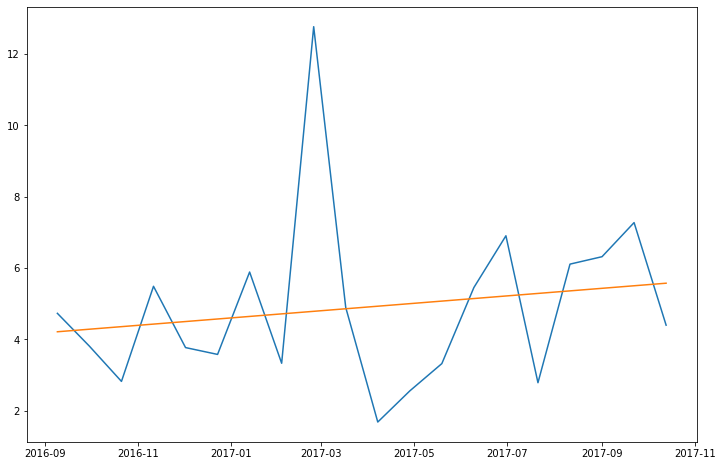

In [81]:
fig = plt.figure(figsize=[12,8])
results_x = [x[0].date() for x in results]
results_y = [x[1] for x in results]
timestamps = [x[0].timestamp() for x in results]
z = np.polyfit(timestamps, results_y, 1)
poly_func = np.poly1d(z)
trend = [poly_func(x) for x in timestamps]
plt.plot(results_x, results_y)
plt.plot(results_x, trend)

In [82]:
z

array([ 3.95061527e-08, -5.39940874e+01])

In [83]:
mape = np.mean(residuals[:21])
print(mape)

NameError: name 'residuals' is not defined

In [84]:
X_train = X_train.append(X_walk1)

In [85]:
m2 = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m2.add_regressor('CA_pop')
m2.add_regressor('la_high')
m2.add_regressor('sd_high')
m2.add_regressor('f_high')
m2.add_regressor('DOW')
m2.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [87]:
forecast2 = m2.predict(X_walk2)
forecast2.index = pd.DatetimeIndex(forecast2['ds'])

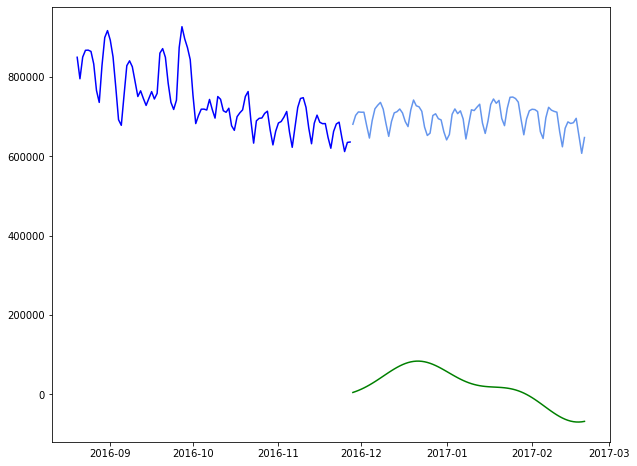

In [89]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk2.index[:100], X_walk2['y'].values[:100], c='cornflowerblue')
plt.plot(X_train.index[-100:], X_train['y'].values[-100:], c='b')
plt.plot(forecast2['ds'].values[:100], forecast2['yearly'].values[:100], c='g')

In [28]:
residuals = [abs(X_walk2.loc[x, 'y'] - forecast2.loc[x, 'yhat'])/ \
             X_walk2.loc[x, 'y'] * 100 for x in forecast2['ds'].values]

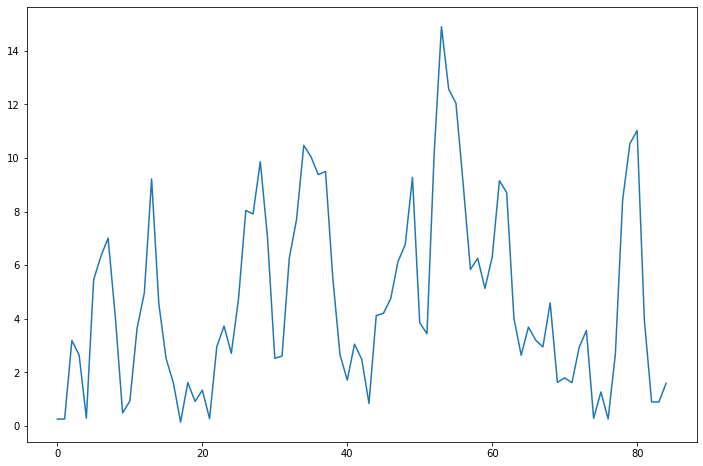

In [29]:
fig = plt.figure(figsize=[12,8])
plt.plot(residuals)

In [30]:
mape = np.mean(residuals[:21])
print(mape)

2.927815699674206


In [31]:
X_train = X_train.append(X_walk2)

In [32]:
m3 = Prophet(weekly_seasonality=True, yearly_seasonality=True)
m3.add_regressor('CA_pop')
m3.add_regressor('la_high')
m3.add_regressor('sd_high')
m3.add_regressor('f_high')
m3.add_regressor('DOW')
m3.fit(X_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
forecast3 = m3.predict(X_walk3)
forecast3.index = pd.DatetimeIndex(forecast3['ds'])

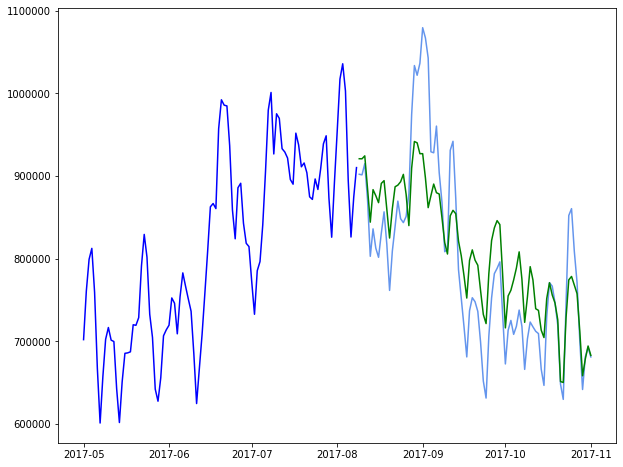

In [34]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk3.index[:100], X_walk3['y'].values[:100], c='cornflowerblue')
plt.plot(X_train.index[-100:], X_train['y'].values[-100:], c='b')
plt.plot(forecast3['ds'].values[:100], forecast3['yhat'].values[:100], c='g')

In [35]:
residuals = [abs(X_walk3.loc[x, 'y'] - forecast3.loc[x, 'yhat'])/ \
             X_walk3.loc[x, 'y'] * 100 for x in forecast3['ds'].values]

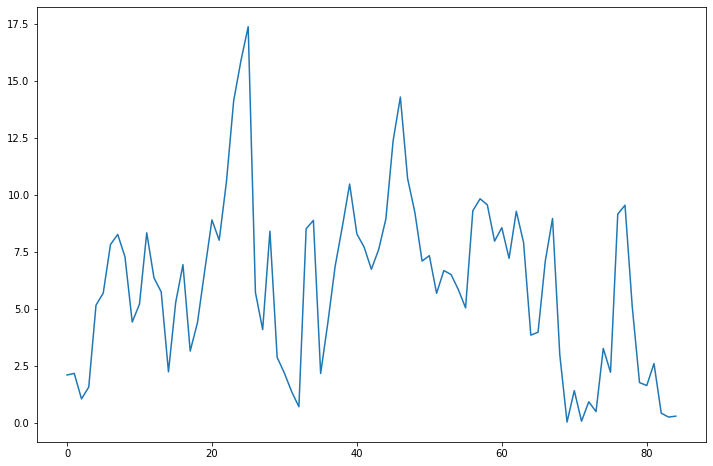

In [36]:
fig = plt.figure(figsize=[12,8])
plt.plot(residuals)

In [37]:
mape = np.mean(residuals[:21])
print(mape)

5.1674035065838515


(array([ 3.,  6.,  4.,  8.,  7., 15., 18., 16.,  6.,  2.]),
 array([ 0.30655902,  2.60574427,  4.90492951,  7.20411476,  9.50330001,
        11.80248526, 14.1016705 , 16.40085575, 18.700041  , 20.99922625,
        23.29841149]),
 <a list of 10 Patch objects>)

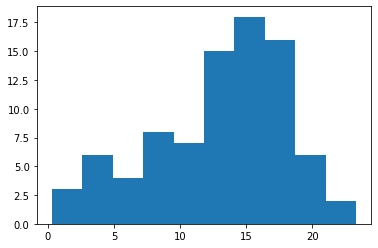

In [20]:
plt.hist(residuals)